_Lambda School Data Science — Model Validation_ 

# Begin the modeling process

Objectives
- Train/Validate/Test split
- Cross-Validation
- Begin with baselines

## Why care about model validation?

Rachel Thomas, [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

> An all-too-common scenario: a seemingly impressive machine learning model is a complete failure when implemented in production. The fallout includes leaders who are now skeptical of machine learning and reluctant to try it again. How can this happen?

> One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). 

Owen Zhang, [Winning Data Science Competitions](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions/8)

> Good validation is _more important_ than good models. 

James, Witten, Hastie, Tibshirani, [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 2.2, Assessing Model Accuracy

> In general, we do not really care how well the method works training on the training data. Rather, _we are interested in the accuracy of the predictions that we obtain when we apply our method to previously unseen test data._ Why is this what we care about? 

> Suppose that we are interested test data in developing an algorithm to predict a stock’s price based on previous stock returns. We can train the method using stock returns from the past 6 months. But we don’t really care how well our method predicts last week’s stock price. We instead care about how well it will predict tomorrow’s price or next month’s price. 

> On a similar note, suppose that we have clinical measurements (e.g. weight, blood pressure, height, age, family history of disease) for a number of patients, as well as information about whether each patient has diabetes. We can use these patients to train a statistical learning method to predict risk of diabetes based on clinical measurements. In practice, we want this method to accurately predict diabetes risk for _future patients_ based on their clinical measurements. We are not very interested in whether or not the method accurately predicts diabetes risk for patients used to train the model, since we already know which of those patients have diabetes.

### We'll look at 4 methods of model validation

- Performance estimation
  - 2-way holdout method (**train/test split**)
  - (Repeated) k-fold **cross-validation without independent test set** 
- Model selection (hyperparameter optimization) and performance estimation ← ***We usually want to do this***
  - 3-way holdout method (**train/validation/test split**)
  - (Repeated) k-fold **cross-validation with independent test set**
  
<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">

Source: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html

## Why begin with baselines?

[My mentor](https://www.linkedin.com/in/jason-sanchez-62093847/) [taught me](https://youtu.be/0GrciaGYzV0?t=40s):

>***Your first goal should always, always, always be getting a generalized prediction as fast as possible.*** You shouldn't spend a lot of time trying to tune your model, trying to add features, trying to engineer features, until you've actually gotten one prediction, at least. 

> The reason why that's a really good thing is because then ***you'll set a benchmark*** for yourself, and you'll be able to directly see how much effort you put in translates to a better prediction. 

> What you'll find by working on many models: some effort you put in, actually has very little effect on how well your final model does at predicting new observations. Whereas some very easy changes actually have a lot of effect. And so you get better at allocating your time more effectively.

My mentor's advice is echoed and elaborated in several sources:

[Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)

> Why start with a baseline? A baseline will take you less than 1/10th of the time, and could provide up to 90% of the results. A baseline puts a more complex model into context. Baselines are easy to deploy.

[Measure Once, Cut Twice: Moving Towards Iteration in Data Science](https://blog.datarobot.com/measure-once-cut-twice-moving-towards-iteration-in-data-science)

> The iterative approach in data science starts with emphasizing the importance of getting to a first model quickly, rather than starting with the variables and features. Once the first model is built, the work then steadily focuses on continual improvement.

[*Data Science for Business*](https://books.google.com/books?id=4ZctAAAAQBAJ&pg=PT276), Chapter 7.3: Evaluation, Baseline Performance, and Implications for Investments in Data

> *Consider carefully what would be a reasonable baseline against which to compare model performance.* This is important for the data science team in order to understand whether they indeed are improving performance, and is equally important for demonstrating to stakeholders that mining the data has added value.

## Baseline is an overloaded term

Baseline has multiple meanings, as discussed in the links above.

#### The score you'd get by guessing a single value

> A baseline for classification can be the most common class in the training dataset.

> A baseline for regression can be the mean of the training labels. —[Will Koehrsen](https://twitter.com/koehrsen_will/status/1088863527778111488)

#### The score you'd get by guessing in a more granular way

> A baseline for time-series regressions can be the value from the previous timestep.

#### Fast, first models that beat guessing

What my mentor was talking about.

#### Complete, tuned "simpler" model

Can be simpler mathematically and computationally. For example, Logistic Regression versus Deep Learning.

Or can be simpler for the data scientist, with less work. For example, a model with less feature engineering versus a model with more feature engineering.

#### Minimum performance that "matters"

To go to production and get business value.

#### Human-level performance 

Your goal may to be match, or nearly match, human performance, but with better speed, cost, or consistency.

Or your goal may to be exceed human performance.


## Weather data —  mean baseline

Let's try baselines for regression.

You can [get Past Weather by Zip Code from Climate.gov](https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table). I downloaded the data for my town: Normal, Illinois.

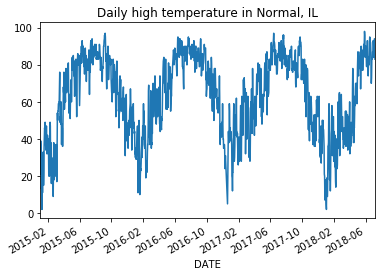

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

url = 'https://raw.githubusercontent.com/rrherr/baselines/master/weather/weather-normal-il.csv'
weather = pd.read_csv(url, parse_dates=['DATE']).set_index('DATE')
weather['2015':'2018'].TMAX.plot()
plt.title('Daily high temperature in Normal, IL');

Over the years, across the seasons, the average daily high temperature in my town is about 63 degrees.

In [2]:
weather.TMAX.mean()

62.562754852389496

If I predicted that every day, the high will be 63 degrees, I'd be off by about 19 degrees on average.

In [3]:
from sklearn.metrics import mean_absolute_error
predicted = [weather.TMAX.mean()] * len(weather)  
mean_absolute_error(weather.TMAX, predicted)

18.684890040509288

But, with time series data like this, we can get a better baseline.

*Data Science for Business* explains, 

> Weather forecasters have two simple—but not simplistic—baseline models that they compare against. ***One (persistence) predicts that the weather tomorrow is going to be whatever it was today.*** The other (climatology) predicts whatever the average historical weather has been on this day from prior years. Each model performs considerably better than random guessing, and both are so easy to compute that they make natural baselines of comparison. Any new, more complex model must beat these.

Let's predict that the weather tomorrow is going to be whatever it was today. Which is another way of saying that the weather today is going to be whatever it was yesterday.

We can engineer this feature with one line of code, using the pandas [`shift`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html) function.

This new baseline is off by less than 6 degress on average.

In [5]:
weather['TMAX_yesterday'] = weather.TMAX.shift(1)
weather.dropna(inplace=True)  # Drops the first date, because it doesn't have a "yesterday"
mean_absolute_error(weather.TMAX, weather.TMAX_yesterday)

5.519655819264334

## Adult Census Income — Train/Test Split — majority class baseline

Load the data. It has already been split into train and test.

https://archive.ics.uci.edu/ml/datasets/adult

In [6]:
names = ['age', 
         'workclass', 
         'fnlwgt', 
         'education', 
         'education-num', 
         'marital-status', 
         'occupation', 
         'relationship', 
         'race', 
         'sex', 
         'capital-gain', 
         'capital-loss', 
         'hours-per-week', 
         'native-country', 
         'income']

train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None, names=names)
test  = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', header=None, names=names, skiprows=[0])

train.shape, test.shape

((32561, 15), (16281, 15))

Assign to X and y

In [7]:
X_train = train.drop(columns='income')
y_train = train.income == ' >50K'

X_test  = test.drop(columns='income')
y_test  = test.income  == ' >50K.'

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32561, 14), (16281, 14), (32561,), (16281,))

Majority class baseline

In [8]:
import numpy as np

majority_class = y_train.mode()[0]
y_pred = np.full(shape=y_test.shape, fill_value=majority_class)

y_pred

array([False, False, False, ..., False, False, False])

`y_pred` has the same shape as `y_test`

In [10]:
assert y_pred.shape==y_test.shape

all predictions are the majority class

In [12]:
assert y_pred.shape==y_test.shape

Baseline accuracy is __% by guessing the majority class for every prediction

In [18]:
from sklearn.metrics import accuracy_score
from numpy.testing import assert_almost_equal

accuracy_score(y_test, y_pred)

0.7637737239727289

This makes sense, because the majority class occurs __% of the time in the test dataset

In [22]:
assert_almost_equal(y_test.value_counts(normalize=True).loc[False], accuracy_score(y_test, y_pred))

## Adult Census Income — Train/Test Split — fast first models

Scikit-learn expects no nulls...

In [24]:
def no_nulls(df):
    return not any(df.isnull().sum())

assert no_nulls(X_train)

Scikit-learn also expects all numeric features. (No strings / "object" datatypes.) ...

In [25]:
def all_numeric(df):
    from pandas.api.types import is_numeric_dtype
    return all(is_numeric_dtype(df[col]) for col in df)

all_numeric(X_train)

False

Instead of encoding nonnumeric features, we can just exclude them from the training data.

In [27]:
X_train_numeric = X_train.select_dtypes(np.number)

all_numeric(X_train_numeric)

True

We'll do the same with the test data.

In [29]:
X_test_numeric = X_test.select_dtypes(np.number)
assert all_numeric(X_train_numeric)

Then fit a Logistic Regression on the training data (only the numeric features).

Test accuracy improves to Almost 80%

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_numeric, y_train)
y_pred = model.predict(X_test_numeric)
accuracy_score(y_test, y_pred)

0.7992138075056815

Let's try scaling our data first. 

Test accuracy improves to Over 81%

In [33]:
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

pipeline.fit(X_train_numeric, y_train)

y_pred = pipeline.predict(X_test_numeric)

accuracy_score(y_test, y_pred)

0.8134635464652048

One-hot-encode all the categorical featues.

Install the Category Encoder library 

https://github.com/scikit-learn-contrib/categorical-encoding

In [34]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 1.1MB/s ta 0:00:01
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
import category_encoders as ce

Add the library's OneHotEncoder to a pipeline.

Before, we fit on `X_train_numeric` and predict on `X_test_numeric`.

Now, we fit on  `X_train` and predict on `X_test` (the original dataframes which include categorical columns)



In [40]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(), 
    LogisticRegression()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.8525274860266568

 Test accuracy improves to 85%!!!


Visualize coefficients

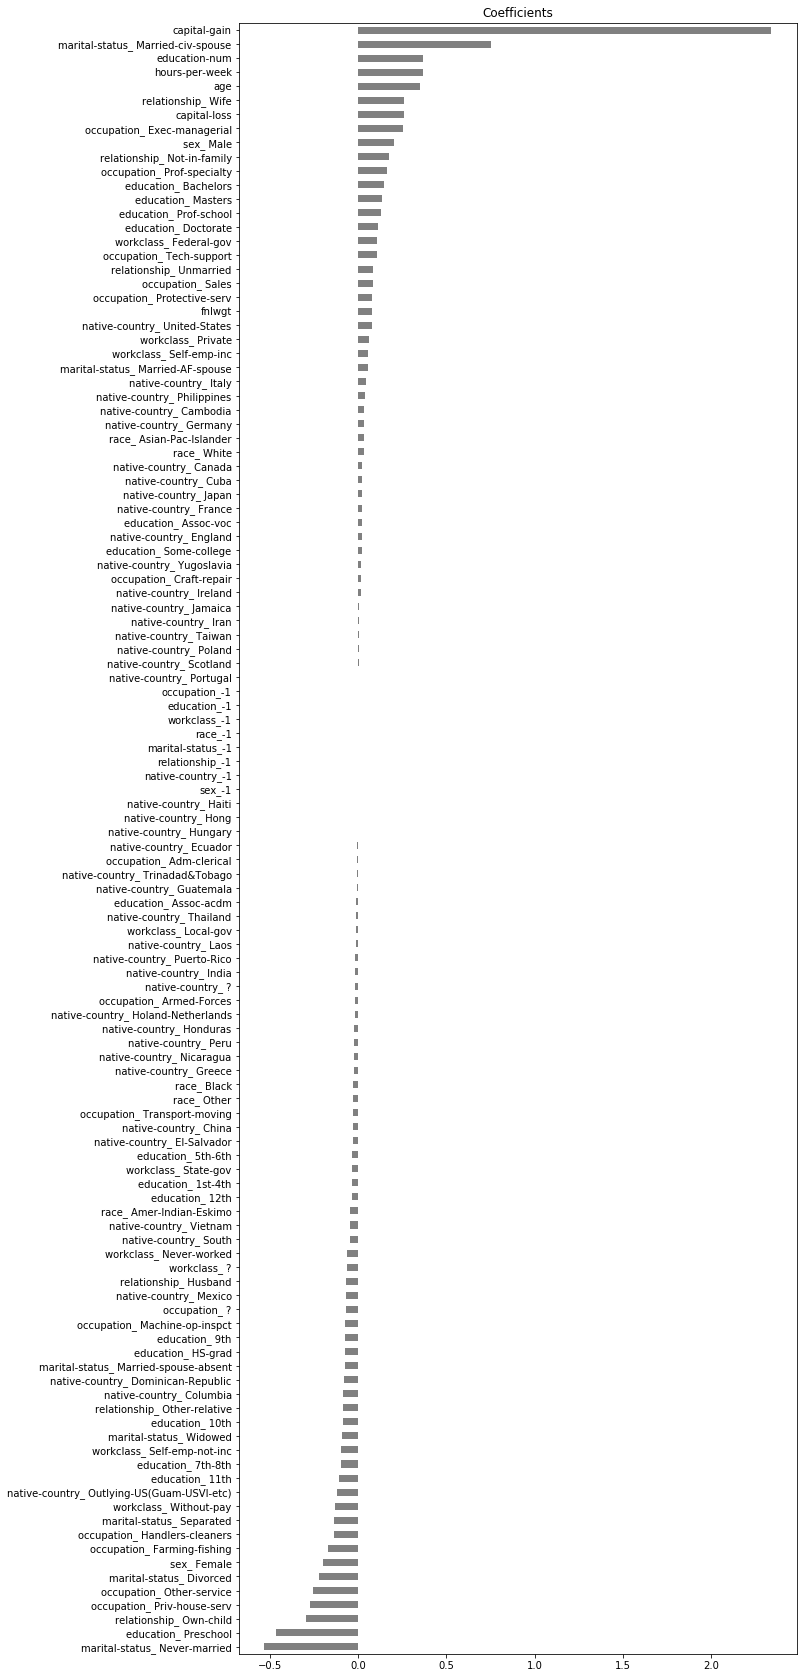

In [41]:
plt.figure(figsize=(10,30))
plt.title('Coefficients')

coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');

## Adult Census Income — Cross Validation with independent test set — fast first models

`cross_val_score(pipeline, X_train, y_train, cv=10)` repeats this process 10 times:
- Use 9/10 of the training data to fit the model pipeline
- Use 1/10 of the training data to predict and score the model pipeline

The test data is not used here — it remains independent, held out.

In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_train, y_train, cv=10) 



`cross_val_score(cv=10)` returns 10 scores

<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/loocv.png" width="400">

Source: https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html

The scores have low variance.

In [45]:
scores.mean(), scores.std()

(0.8516938663200561, 0.004862804268083401)

<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part2/visual_bias_variance.png" width="400">

Source: https://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html

## Adult Census Income — Train/Validation/Test split — fast first models

How to get from a two-way split ...

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32561, 14), (16281, 14), (32561,), (16281,))

... to a three-way split?

Can use the `sklearn.model_selection.train_test_split` function to split the training data into training and validation data.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [49]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((24420, 14), (8141, 14), (16281, 14), (24420,), (8141,), (16281,))

Fit on the training set.

Predict and score with the validation set.

Do not use the test set.

In [50]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

0.8474388895713058

## What to do with the test set?

Hold it out. Keep it in a "vault." Don't touch it until you're done with your models. 

Here's one way to save your test set for later, with the feather file format.

https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-feather

In [51]:
!pip install -U feather-format

    100% |████████████████████████████████| 12.5MB 986kB/s ta 0:00:011
  Running setup.py bdist_wheel for feather-format ... done
  Stored in directory: /home/quinn/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
Successfully built feather-format
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [55]:
X_test.reset_index(drop=True).to_feather('X_test.feather')
pd.DataFrame(y_test).reset_index(drop=True).to_feather('y_test.feather')

You can save the files from Google Colab to your local machine

In [54]:
# from google.colab import files
# files.download('X_test.feather')
# files.download('y_test.feather')

You can delete the variables from your notebook's runtime

In [0]:
# del X_test, y_test

## Why hold out an independent test set?

Owen Zhang, [Winning Data Science Competitions](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions)

- There are many ways to overfit. Beware of "multiple comparison fallacy." There is a cost in "peeking at the answer."
- Good validation is _more important_ than good models. Simple training/validation split is _not_ enough. When you looked at your validation result for the Nth time, you are training models on it.
- If possible, have "holdout" dataset that you do not touch at all during model build process. This includes feature extraction, etc.
- What if holdout result is bad? Be brave and scrap the project.

Hastie, Tibshirani, and Friedman, [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/), Chapter 7: Model Assessment and Selection

> If we are in a data-rich situation, the best approach is to randomly divide the dataset into three parts: a training set, a validation set, and a test set. The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model. Ideally, the test set should be kept in a "vault," and be brought out only at the end of the data analysis. Suppose instead that we use the test-set repeatedly, choosing the model with the smallest test-set error. Then the test set error of the final chosen model will underestimate the true test error, sometimes substantially.

Andreas Mueller and Sarah Guido, [Introduction to Machine Learning with Python](https://books.google.com/books?id=1-4lDQAAQBAJ&pg=PA270)

> The distinction between the training set, validation set, and test set is fundamentally important to applying machine learning methods in practice. Any choices made based on the test set accuracy "leak" information from the test set into the model. Therefore, it is important to keep a separate test set, which is only used for the final evaluation. It is good practice to do all exploratory analysis and model selection using the combination of a training and a validation set, and reserve the test set for a final evaluation - this is even true for exploratory visualization. Strictly speaking, evaluating more than one model on the test set and choosing the better of the two will result in an overly optimistic estimate of how accurate the model is.

Hadley Wickham, [R for Data Science](https://r4ds.had.co.nz/model-intro.html#hypothesis-generation-vs.hypothesis-confirmation)

> There is a pair of ideas that you must understand in order to do inference correctly:

> 1. Each observation can either be used for exploration or confirmation, not both.

> 2. You can use an observation as many times as you like for exploration, but you can only use it once for confirmation. As soon as you use an observation twice, you’ve switched from confirmation to exploration.

> This is necessary because to confirm a hypothesis you must use data independent of the data that you used to generate the hypothesis. Otherwise you will be over optimistic. There is absolutely nothing wrong with exploration, but you should never sell an exploratory analysis as a confirmatory analysis because it is fundamentally misleading.

> If you are serious about doing an confirmatory analysis, one approach is to split your data into three pieces before you begin the analysis.

## Should you shuffle?

Sometimes yes, sometimes no. Experts may seem to give conflicting advice! Partly, that perception is true. Partly, the right choices depend on your data and your goals.

[Hastie, Tibshirani, and Friedman](http://statweb.stanford.edu/~tibs/ElemStatLearn/) write,
> randomly divide the dataset into three parts: a training set, a validation set, and a test set. 

But [Rachel Thomas](
https://www.fast.ai/2017/11/13/validation-sets/) asks, "When is a random subset not good enough?" and gives many good examples.
> If your data is a time series, choosing a random subset of the data will be both too easy (you can look at the data both before and after the dates your are trying to predict) and not representative of most business use cases (where you are using historical data to build a model for use in the future).

> In the Kaggle distracted driver competition, the independent data are pictures of drivers at the wheel of a car, and the dependent variable is a category such as texting, eating, or safely looking ahead. If you were the insurance company building a model from this data, note that you would be most interested in how the model performs on drivers you haven’t seen before (since you would likely have training data only for a small group of people). 

> A similar dynamic was at work in the Kaggle fisheries competition to identify the species of fish caught by fishing boats in order to reduce illegal fishing of endangered populations. The test set consisted of boats that didn’t appear in the training data. This means that you’d want your validation set to include boats that are not in the training set.




[Owen Zhang](https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions/10) recommends using your most recent data for your hold out test set, instead of choosing your test set with random shuffling. But he says you are free to use random splits to train and tune models.

> Make validation dataset as realistic as possible. Usually this means "out-of-time" validation. You are free to use "in-time" random split to build models, tune parameters, etc. But hold out data should be out-of-time.

Note that Owen Zhang's slide could be confusing, because of ambiguous terminology:
- What he calls "validation dataset" and "hold out data" is what we're calling "test set."
- He also says "cross-validation" is an "exception to the rule" to use "when data is extremely small." There he is talking about "Cross-validation _without_ independent test set", _not_ "Cross-validation _with_ independent test set."

**Sometimes you need to shuffle, like in this next example:**

## Iris flowers — Train/Validation/Test split?

Load the Iris dataset

In [56]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

What would happen if you didn't shuffle this data?

In [57]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Let's try it!

We'll do a train/validation/test split, with and without random shuffling.

[Rachel Thomas]( https://www.fast.ai/2017/11/13/validation-sets/) points out that "sklearn has a `train_test_split` method, but no `train_validation_test_split`."

So we can write our own:


In [8]:
def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test



Split Iris data into train/validation/test sets, _without_ random shuffling

In [59]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, shuffle=False)

Look at the train, validation, and test targets

In [60]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [61]:
y_val

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [62]:
y_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Split Iris data into train/validation/test sets, _with_ random shuffling

In [63]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, shuffle=True)

Look at the train, validation, and test targets

In [64]:
y_train

array([1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 0, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 2, 1, 2, 0, 2, 2, 0, 0, 1, 0, 2, 1, 0, 2, 2, 0, 2, 0, 0, 2, 0,
       1, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0, 2, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 0, 2, 1, 0, 1])

In [65]:
y_val

array([0, 1, 1, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 2, 2, 2])

In [66]:
y_test

array([2, 0, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0])

That's better, but there's just not enough data for a three-way split. In fact, there's not much data for a two-way split. The Iris dataset is a rare example where you probably do want to use cross-validation _without_ an independent test set.

## Bank Marketing — shuffled or split by time?

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

bank-additional-full.csv with all examples (41188) and 20 inputs, **ordered by date (from May 2008 to November 2010)**

In [68]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

--2019-01-28 13:47:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/zip]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 434.15K   719KB/s    in 0.6s    

2019-01-28 13:47:43 (719 KB/s) - ‘bank-additional.zip.1’ saved [444572/444572]



In [69]:
!unzip bank-additional.zip

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [73]:
%cd bank-additional

[Errno 2] No such file or directory: 'bank-additional'
/home/quinn/Projects/DS1/DS-Unit-2-Sprint-4-Model-Validation/module-1-begin-modeling-process/bank-additional


In [7]:

import pandas as pd
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from numpy.testing import assert_almost_equal
from functools import reduce
import matplotlib.pyplot as plt


In [3]:


bank = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = bank.drop(columns='y')
y = bank['y'] == 'yes'

### Shuffled split?

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X, y, shuffle=True)

In [10]:
[array.shape for array in (X_train, X_val, X_test, y_train, y_val, y_test)]

[(32950, 20), (4119, 20), (4119, 20), (32950,), (4119,), (4119,)]

In [13]:
print(y_train.mean(), y_val.mean(), y_test.mean())

#y_val.rolling(1000).mean().plot();

0.11223065250379363 0.11823258072347657 0.11046370478271425


### Split by time?

In [78]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(X, y, shuffle=False)

In [79]:
[array.shape for array in (X_train, X_val, X_test, y_train, y_val, y_test)]

[(32950, 20), (4119, 20), (4119, 20), (32950,), (4119,), (4119,)]

In [80]:
y_train.mean(), y_val.mean(), y_test.mean()

(0.0637329286798179, 0.157319737800437, 0.4593347899975722)

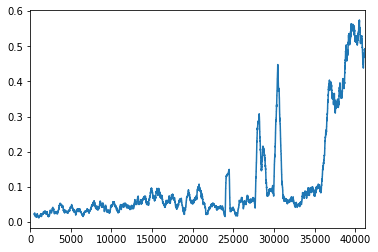

In [81]:
y.rolling(500).mean().plot();

***The "right" choice here is unclear, but either way, it will make a big difference!***

# ASSIGNMENT options

- Replicate the lesson code. [Do it "the hard way" or with the "Benjamin Franklin method."](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit)
- Apply the lesson to other datasets you've worked with before, and compare results.
- Choose how to split the Bank Marketing dataset. Train and validate baseline models.
- Get weather data for your own area and calculate both baselines.  _"One (persistence) predicts that the weather tomorrow is going to be whatever it was today. The other (climatology) predicts whatever the average historical weather has been on this day from prior years."_ What is the mean absolute error for each baseline? What if you average the two together? 
- When would this notebook's pipelines fail? How could you fix them? Add more [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) and [imputation](https://scikit-learn.org/stable/modules/impute.html) to your [pipelines](https://scikit-learn.org/stable/modules/compose.html) with scikit-learn.
- [This example from scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html) demonstrates its improved `OneHotEncoder` and new `ColumnTransformer` objects, which can replace functionality from third-party libraries like category_encoders and sklearn-pandas. Adapt this example, which uses Titanic data, to work with another dataset.




